## Lecture 4 — Data (BCRP + Yahoo) + Plots + Stats + VaR

Reproduce the key parts of the lecture notebook using:

- **Peru (BCRP API)**: `PD04637PD`, `PD04639PD`, `PD04704XD`, `PD04701XD`  
  *(FX + commodities exactly as in the notebook)*
- **USA (yfinance)**: `SPY`, `TLT`, `GLD`

**Deliverables**
- Multiple **plots** (including **one with annotations**)  
- A **summary statistics table**  
- **Historical 95% VaR** for a **60/40 portfolio** (SPY/TLT)

In [1]:
# Importing libraries. Install if you don't have them
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.max_columns", 120)

1. Build (and display) the **BCRPData API URL** that requests the 4 series used in the notebook.  


In [2]:
from __future__ import annotations

from pathlib import Path
import hashlib
import re
from io import StringIO

import numpy as np
import pandas as pd

# Configuration


CACHE_DIR = Path(".cache")
CACHE_DIR.mkdir(exist_ok=True)

# Cache utilities (parquet -> csv fallback)

def _hash_key(*parts: object) -> str:
    h = hashlib.sha256()
    for p in parts:
        h.update(str(p).encode("utf-8"))
        h.update(b"|")
    return h.hexdigest()[:24]

def _cache_paths(prefix: str, key: str) -> tuple[Path, Path]:
    p_parquet = CACHE_DIR / f"{prefix}_{key}.parquet"
    p_csv = CACHE_DIR / f"{prefix}_{key}.csv"
    return p_parquet, p_csv

def _read_cache_df(prefix: str, key: str) -> pd.DataFrame | None:
    p_parquet, p_csv = _cache_paths(prefix, key)
    if p_parquet.exists():
        try:
            return pd.read_parquet(p_parquet)
        except Exception:
            pass
    if p_csv.exists():
        try:
            return pd.read_csv(p_csv)
        except Exception:
            pass
    return None

def _write_cache_df(df: pd.DataFrame, prefix: str, key: str) -> None:
    p_parquet, p_csv = _cache_paths(prefix, key)
    try:
        df.to_parquet(p_parquet, index=False)
        return
    except Exception:
        pass
    try:
        df.to_csv(p_csv, index=False)
    except Exception:
        # If caching fails, ignore silently (no exceptions)
        return

# HTTP helpers

def http_get_text(url: str, timeout: int = 30, headers: dict | None = None) -> str:
    """
    Returns response text. Raises inside, but callers wrap in try/except (no exceptions to user).
    """
    import requests

    h = {
        "User-Agent": "Mozilla/5.0 (compatible; FinanceCourse/1.0)",
        "Accept": "*/*",
    }
    if headers:
        h.update(headers)

    r = requests.get(url, timeout=timeout, headers=h)
    r.raise_for_status()
    return r.text
# Numeric + returns helpers
def parse_number(x) -> float:
    """
    Robust number parser:
      - '3,367' -> 3.367 (comma decimal)
      - '1,234.56' -> 1234.56 (comma thousands)
    """
    if x is None:
        return np.nan
    s = str(x).strip()
    if s == "" or s.lower() in {"nan", "none"}:
        return np.nan

    if "," in s and "." in s:
        s = s.replace(",", "")
    elif "," in s and "." not in s:
        s = s.replace(",", ".")

    try:
        return float(s)
    except Exception:
        return np.nan

def pct_change(s: pd.Series) -> pd.Series:
    x = pd.to_numeric(s, errors="coerce")
    return x.pct_change(fill_method=None).replace([np.inf, -np.inf], np.nan)
# BCRP parsing

_SP2EN = {
    "Ene": "Jan", "Feb": "Feb", "Mar": "Mar", "Abr": "Apr", "May": "May", "Jun": "Jun",
    "Jul": "Jul", "Ago": "Aug", "Set": "Sep", "Sep": "Sep", "Oct": "Oct", "Nov": "Nov", "Dic": "Dec",
}

def _clean_bcrp_payload(txt: str) -> str:
    """
    BCRP sometimes returns "CSV" wrapped as HTML with <br> line breaks.
    Normalize to plain text with real newlines.
    """
    x = txt.replace("\r\n", "\n").replace("\r", "\n")
    x = x.replace("<br/>", "\n").replace("<br />", "\n").replace("<br>", "\n")
    x = re.sub(r"</?pre[^>]*>", "", x, flags=re.IGNORECASE)
    return x.strip()

def _detect_sep(header_line: str) -> str:
    return ";" if header_line.count(";") > header_line.count(",") else ","

def _parse_bcrp_date(s: pd.Series) -> pd.Series:
    """
    Parses common BCRP date formats:
      - Daily: 2022-01-03, 03Jan22, 03Ene22
      - Monthly: Jan22, Ene22, 2022-1, 2022-01
      - Yearly: 2022
    """
    x = s.astype(str).str.strip()
    x = x.str.replace(".", "", regex=False)

    y = x
    for k, v in _SP2EN.items():
        y = y.str.replace(k, v, regex=False)

    dt = pd.to_datetime(y, format="%Y-%m-%d", errors="coerce")

    m = dt.isna()
    if m.any():
        dt.loc[m] = pd.to_datetime(y[m], format="%d%b%y", errors="coerce")

    m = dt.isna()
    if m.any():
        dt.loc[m] = pd.to_datetime(y[m], format="%b%y", errors="coerce")

    m = dt.isna()
    if m.any():
        dt.loc[m] = pd.to_datetime(y[m], format="%Y-%m", errors="coerce")

    m = dt.isna()
    if m.any():
        dt.loc[m] = pd.to_datetime(y[m], format="%Y", errors="coerce")

    m = dt.isna()
    if m.any():
        dt.loc[m] = pd.to_datetime(y[m], errors="coerce")

    return dt


def bcrp_series_csv(
    series_codes: list[str],
    start: str,
    end: str,
    lang: str = "ing",
) -> pd.DataFrame:
    """
    BCRPData API (CSV):
      https://estadisticas.bcrp.gob.pe/estadisticas/series/api/[codes]/csv/[start]/[end]/[lang]

    Returns LONG DataFrame:
      date, series_name, value

    If the endpoint fails, prints a short message and returns an empty DataFrame (no exceptions).
    """
    codes = "-".join(series_codes)
    url = f"https://estadisticas.bcrp.gob.pe/estadisticas/series/api/{codes}/csv/{start}/{end}/{lang}"

    key = _hash_key("bcrp", url)
    cached = _read_cache_df("bcrp", key)
    if cached is not None and cached.shape[0] > 0:
        cached["date"] = pd.to_datetime(cached["date"], errors="coerce")
        return cached

    try:
        txt = http_get_text(url, timeout=30)
        txt = _clean_bcrp_payload(txt)

        lines = [ln for ln in txt.split("\n") if ln.strip() != ""]
        if len(lines) < 2:
            print("[BCRP] Endpoint returned no usable rows. Continuing...")
            return pd.DataFrame(columns=["date", "series_name", "value"])

        sep = _detect_sep(lines[0])
        df = pd.read_csv(StringIO("\n".join(lines)), sep=sep)

        if df.shape[0] == 0 or df.shape[1] < 2:
            print("[BCRP] Returned an empty table. Continuing...")
            return pd.DataFrame(columns=["date", "series_name", "value"])

        date_col = df.columns[0]
        value_cols = list(df.columns[1:])

        out = df.melt(
            id_vars=[date_col],
            value_vars=value_cols,
            var_name="series_name",
            value_name="value_raw",
        ).rename(columns={date_col: "date"})

        out["date"] = _parse_bcrp_date(out["date"])
        out["value"] = out["value_raw"].map(parse_number)

        out = out.drop(columns=["value_raw"])
        out = out.dropna(subset=["date"]).sort_values(["series_name", "date"]).reset_index(drop=True)

        _write_cache_df(out, "bcrp", key)
        return out

    except Exception as e:
        print(f"[BCRP] Endpoint unavailable ({type(e).__name__}). Continuing...")
        return pd.DataFrame(columns=["date", "series_name", "value"])

In [3]:
START_D = "2022-01-01"
END_D   = "2025-12-18"

bcrp = bcrp_series_csv(
    series_codes=["PD04637PD", "PD04639PD", "PD04704XD", "PD04701XD"],
    start=START_D,
    end=END_D,
    lang="ing"
)

2. Download those series and build a **tidy** table: `date`, `series`, `value`.  


In [4]:
# # Using the bcrp_series_csv helper function
# bcrp_df = bcrp_series_csv(

#     series_codes=series_codes,
#     start='2000-01-01', # Start date for data download (adjust as needed)
#     end='2023-12-31' # End date for data download (adjust as needed)
# )

# print('Tidy BCRP Data:')
# display(bcrp_df.head())
# print('\nData Types:')
# display(bcrp_df.info())

In [5]:
# Using the bcrp_series_csv helper function
series_codes = ['PD04637PD', 'PD04639PD', 'PD04704XD', 'PD04701XD'] # Define series_codes here
bcrp_df = bcrp_series_csv(
    series_codes=series_codes,
    start='2000-01-01', # Start date for data download (adjust as needed)
    end='2023-12-31' # End date for data download (adjust as needed)
)

print('Tidy BCRP Data:')
display(bcrp_df.head())
print('\nData Types:')
display(bcrp_df.info())

[BCRP] Endpoint unavailable (HTTPError). Continuing...
Tidy BCRP Data:


,date,series_name,value



Data Types:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 0 entries
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   date         0 non-null      object
 1   series_name  0 non-null      object
 2   value        0 non-null      object
dtypes: object(3)
memory usage: 132.0+ bytes


None

3. Clean to **wide format** with columns: `fx_interbank`, `fx_sbs`, `gold`, `copper` (as in the notebook).  


In [6]:

# show in English (wide + renamed)
bcrp_wide = (
    bcrp.pivot_table(index="date", columns="series_name", values="value", aggfunc="last")
        .reset_index()
        .sort_values("date")
)
bcrp_wide.columns.name = None

rename_map = {}
for c in bcrp_wide.columns:
    cl = str(c).lower()
    if "interbanc" in cl and ("tipo de cambio" in cl or "tc" in cl or "exchange" in cl):
        rename_map[c] = "fx_interbank_buy"
    elif "sbs" in cl and ("tipo de cambio" in cl or "tc" in cl or "exchange" in cl):
        rename_map[c] = "fx_sbs_buy"
    elif "oro" in cl or "gold" in cl:
        rename_map[c] = "gold_london"
    elif "cobre" in cl or "copper" in cl:
        rename_map[c] = "copper_london"

bcrp_wide = bcrp_wide.rename(columns=rename_map)
bcrp_wide.head()

,date,copper_london,gold_london,fx_interbank_buy,fx_sbs_buy
0,2022-01-03,439.621725,1820.10,3.983667,3.987
1,2022-01-04,438.170229,1811.40,3.959500,3.963
2,2022-01-05,443.522619,1826.25,3.952000,3.953
3,2022-01-06,433.861102,1789.35,3.967167,3.967
4,2022-01-07,436.129064,1792.60,3.945167,3.948


4. Download `SPY`, `TLT`, `GLD` from yfinance and build: `date`, `ticker`, `close`.  


In [7]:
# Yahoo Finance (yfinance)

def yfinance_download(tickers: list[str], start: str, end: str) -> pd.DataFrame:
    """
    Yahoo Finance via yfinance.
    Returns LONG DataFrame:
      date, ticker, close, volume, ret

    If the endpoint fails, prints a short message and returns an empty DataFrame (no exceptions).
    """
    try:
        import yfinance as yf
    except Exception:
        print("[yfinance] yfinance not installed/importable. Continuing...")
        return pd.DataFrame(columns=["date", "ticker", "close", "volume", "ret"])

    key = _hash_key("yfinance", " ".join(tickers), start, end)
    cached = _read_cache_df("yf", key)
    if cached is not None and cached.shape[0] > 0:
        cached["date"] = pd.to_datetime(cached["date"], errors="coerce")
        return cached

    try:
        data = yf.download(tickers=tickers, start=start, end=end, auto_adjust=False, progress=False)
        if data is None or data.shape[0] == 0:
            print("[yfinance] Returned no rows. Continuing...")
            return pd.DataFrame(columns=["date", "ticker", "close", "volume", "ret"])

        frames = []
        if isinstance(data.columns, pd.MultiIndex):
            for t in tickers:
                if t not in data.columns.get_level_values(1):
                    continue
                sub = data.xs(t, axis=1, level=1).copy()
                sub = sub.reset_index().rename(columns={"Date": "date", "Datetime": "date"})
                sub["ticker"] = t
                sub = sub.rename(columns={"Close": "close", "Volume": "volume"})
                frames.append(sub[["date", "ticker", "close", "volume"]])
            out = pd.concat(frames, ignore_index=True) if frames else pd.DataFrame()
        else:
            out = data.reset_index().rename(columns={"Date": "date", "Datetime": "date"})
            out["ticker"] = tickers[0]
            out = out.rename(columns={"Close": "close", "Volume": "volume"})
            out = out[["date", "ticker", "close", "volume"]]

        out["date"] = pd.to_datetime(out["date"], errors="coerce")
        out["close"] = pd.to_numeric(out["close"], errors="coerce")
        out["volume"] = pd.to_numeric(out["volume"], errors="coerce")

        out = out.dropna(subset=["date", "close"]).sort_values(["ticker", "date"]).reset_index(drop=True)
        out["ret"] = out.groupby("ticker")["close"].apply(pct_change).reset_index(level=0, drop=True)

        _write_cache_df(out, "yf", key)
        return out

    except Exception as e:
        print(f"[yfinance] Endpoint unavailable ({type(e).__name__}). Continuing...")
        return pd.DataFrame(columns=["date", "ticker", "close", "volume", "ret"])

In [8]:
usa = yfinance_download(["SPY", "TLT", "GLD"], start=START_D, end=END_D)

5. Compute **daily returns** by ticker (`ret`) and validate there are **no inf values**.  


In [9]:
if usa.shape[0] == 0:
    # If the USA dataset has zero rows, it means we couldn't download data (or it's empty).
    print("USA data is empty (yfinance unavailable).")
else:
    # Make a copy so we don't modify the original `usa` DataFrame.
    df = usa.copy()
    # Convert the 'date' column to pandas datetime (invalid parses become NaT).
    df["date"] = pd.to_datetime(df["date"], errors="coerce")

    # Ensure the return column `ret` exists (or compute it if it is missing / all NaN).
    if "ret" not in df.columns or df["ret"].isna().all():
        # Sort by ticker then date so returns are computed in chronological order per ticker.
        df = df.sort_values(["ticker", "date"]).reset_index(drop=True)

        # Compute daily percent change in 'close' for each ticker group.
        # The first observation per ticker will have NaN return by definition.
        df["ret"] = df.groupby("ticker")["close"].apply(pct_change).reset_index(level=0, drop=True)

6. *(Quantities)* Compare FX levels in Peru: produce a **plot** and a short comment.  


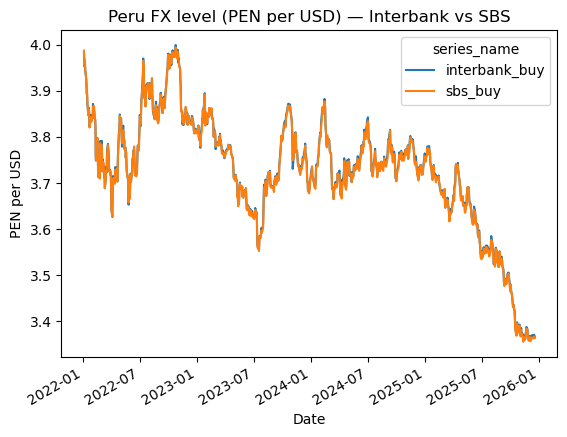

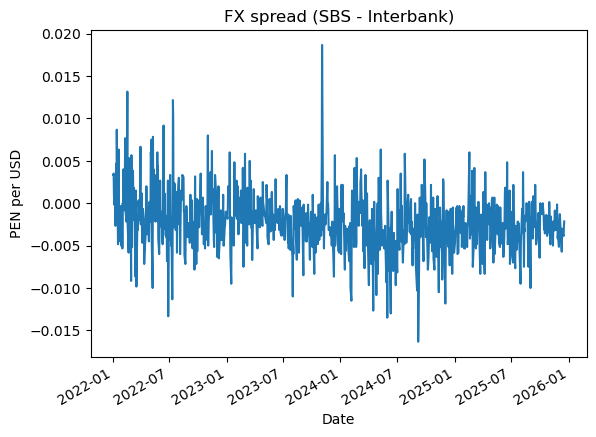

FX wide rows: 988


series_name,interbank_buy,sbs_buy,spread
date,,,
2022-01-03,3.983667,3.987,0.003333
2022-01-04,3.959500,3.963,0.003500
2022-01-05,3.952000,3.953,0.001000
2022-01-06,3.967167,3.967,-0.000167
2022-01-07,3.945167,3.948,0.002833


In [10]:
if bcrp.shape[0] == 0:
    print("BCRP data is empty (BCRPData unavailable).")
else:
    df = bcrp.copy()
    df["date"] = pd.to_datetime(df["date"], errors="coerce")

    # 1 Filter to the two FX series (robust to Spanish/English names)
    name = df["series_name"].astype(str).str.lower()

    fx_hint = name.str.contains("tipo de cambio") | name.str.contains("exchange rate") | name.str.contains("tc ")
    interbank_mask = fx_hint & (name.str.contains("interbanc") | name.str.contains("interbank"))
    sbs_mask       = fx_hint & (name.str.contains("sbs"))

    fx = df[interbank_mask | sbs_mask].dropna(subset=["date"]).copy()

    if fx.shape[0] == 0:
        print("Could not detect FX series in `bcrp`. Check `bcrp['series_name'].unique()`.")
    else:
        # Keep only date/series/value and ensure numeric
        fx["value"] = pd.to_numeric(fx["value"], errors="coerce")
        fx = fx.dropna(subset=["value"])

        # Identify the exact column names found
        interbank_names = fx.loc[interbank_mask[fx.index], "series_name"].unique()
        sbs_names       = fx.loc[sbs_mask[fx.index], "series_name"].unique()

        if len(interbank_names) == 0 or len(sbs_names) == 0:
            print("Detected FX rows, but could not separate Interbank vs SBS cleanly.")
            print("Series found:\n", fx["series_name"].value_counts())
        else:
            interbank_name = interbank_names[0]
            sbs_name = sbs_names[0]

            # 2 Pivot to wide format (date as index)
            fx_wide = (
                fx.pivot_table(index="date", columns="series_name", values="value", aggfunc="last")
                  .sort_index()
            )

            # Rename to clean column names
            fx_wide = fx_wide.rename(columns={
                interbank_name: "interbank_buy",
                sbs_name: "sbs_buy",
            })

            # Drop rows where both are missing
            fx_wide = fx_wide.dropna(subset=["interbank_buy", "sbs_buy"], how="all")

            # 3 Plot both FX levels in the same line chart
            ax = fx_wide[["interbank_buy", "sbs_buy"]].plot(title="Peru FX level (PEN per USD) — Interbank vs SBS")
            ax.set_xlabel("Date")
            ax.set_ylabel("PEN per USD")
            plt.show()

            # 4 Create spread = sbs - interbank and plot it separately
            fx_wide["spread"] = fx_wide["sbs_buy"] - fx_wide["interbank_buy"]

            ax2 = fx_wide["spread"].plot(title="FX spread (SBS - Interbank)")
            ax2.set_xlabel("Date")
            ax2.set_ylabel("PEN per USD")
            plt.show()

            # Optional: quick sanity check
            print("FX wide rows:", fx_wide.shape[0])
            display(fx_wide.head())

7. *(Proportions)* Compute the **share of positive-return days** by ticker (USA).  


In [11]:
if usa.shape[0] == 0:
    print("USA data is empty (yfinance unavailable).")
else:
    # Make a copy of usa data to avoid modifying the original 'usa' DataFrame directly
    usa_df_for_ret = usa.copy()

    # Convert the 'date' column to pandas datetime (invalid parses become NaT).
    usa_df_for_ret["date"] = pd.to_datetime(usa_df_for_ret["date"], errors="coerce")

    # Ensure the return column `ret` exists (or compute it if it is missing / all NaN).
    if "ret" not in usa_df_for_ret.columns or usa_df_for_ret["ret"].isna().all():
        # Sort by ticker then date so returns are computed in chronological order per ticker.
        usa_df_for_ret = usa_df_for_ret.sort_values(["ticker", "date"]).reset_index(drop=True)
        # Compute daily percent change in 'close' for each ticker group.
        usa_df_for_ret["ret"] = usa_df_for_ret.groupby("ticker")["close"].apply(pct_change).reset_index(level=0, drop=True)

    # Now, proceed with computing the share of positive returns using usa_df_for_ret
    shares = (
        usa_df_for_ret.dropna(subset=["ret"]) # Drop rows where ret is missing
        .groupby("ticker")["ret"]
        .apply(lambda s: (s > 0).mean())
        .sort_values(ascending=False)
    )

    # Display the shares as a one-column DataFrame named 'share_positive'
    display(shares.to_frame(name='share_positive_returns'))


,share_positive_returns
ticker,
GLD,0.545821
SPY,0.535750
TLT,0.493454


8. Plot that share as a **bar chart** and add **labels above each bar** (`annotate`).  


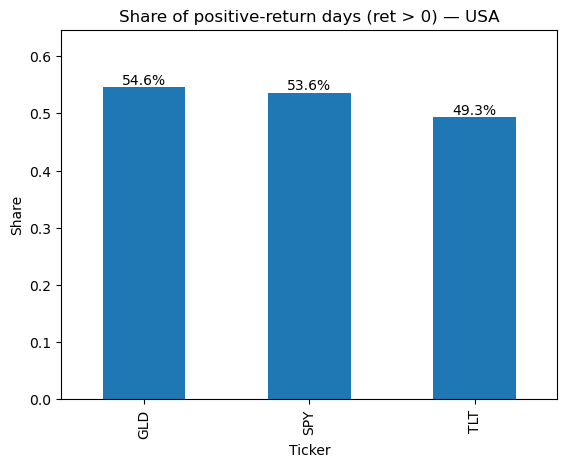

In [12]:
    # 2 Create a bar chart of the shares.
    ax = shares.plot(kind="bar", title="Share of positive-return days (ret > 0) — USA")
    # Set x-axis label.
    ax.set_xlabel("Ticker")
    # Set y-axis label.
    ax.set_ylabel("Share")
    # 3 Add percentage labels on top of each bar.
    for p in ax.patches:
        # Get the bar height (the share value).
        h = p.get_height()

        # Write the label at the top center of the bar (formatted as percent with 1 decimal).
        ax.annotate(
            f"{h:.1%}",
            (p.get_x() + p.get_width() / 2, h),
            ha="center",
            va="bottom",
            fontsize=10
        )
    # Set the y-axis limit: start at 0 and leave ~10% headroom above the max share.
    ax.set_ylim(0, min(1.0, float(shares.max()) + 0.10))
    # Display the plot.
    plt.show()


9. *(Distributions)* Compare the distribution of **Peru Gold** vs **GLD** (histogram).  


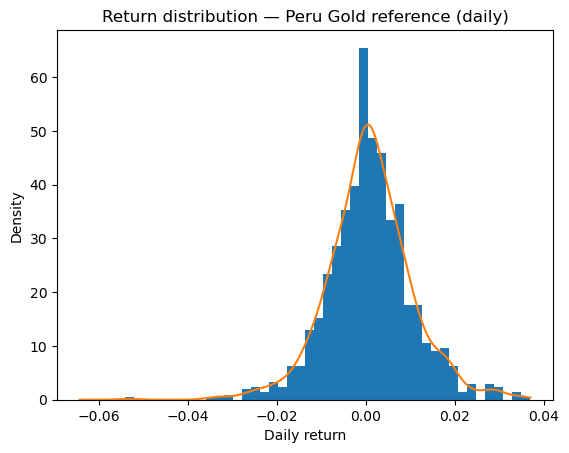

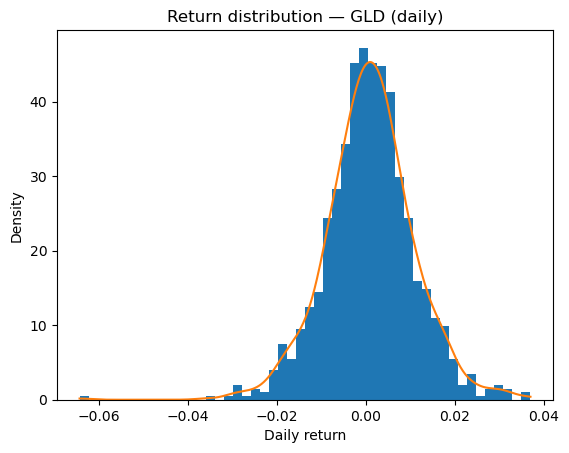

Peru gold return obs: 1033 | GLD return obs: 993


In [13]:
try:
    # Try to import KDE function from SciPy (optional dependency)
    from scipy.stats import gaussian_kde
    HAS_SCIPY = True  # flag: we can plot KDE
except Exception:
    HAS_SCIPY = False  # flag: SciPy not available, skip KDE
# If either Peru or USA dataset is empty, we cannot run the exercise
if bcrp.shape[0] == 0 or usa.shape[0] == 0:
    print("Missing Peru or USA data.")
else:
    # 1 Peru: build daily gold series and compute returns


    p = bcrp.copy()  # copy to avoid modifying the original DataFrame
    p["date"] = pd.to_datetime(p["date"], errors="coerce")  # ensure date is datetime

    # Create a lowercased version of the series name for robust text matching
    sname = p["series_name"].astype(str).str.lower()

    # Identify gold rows by searching for "oro" (Spanish) or "gold" (English)
    gold_mask = sname.str.contains("oro") | sname.str.contains("gold")
    gold_peru = (
        p[gold_mask][["date", "value"]]
          .dropna(subset=["date"])
          .assign(value=lambda d: pd.to_numeric(d["value"], errors="coerce"))
          .dropna(subset=["value"])
          .sort_values("date")
          .groupby("date", as_index=False)["value"].last()
          .rename(columns={"value": "gold_peru"})
    )

    # Compute daily returns for Peru gold (percent change)
    gold_peru["ret"] = pct_change(gold_peru["gold_peru"])

    # Keep only non-missing returns
    gold_peru_ret = gold_peru["ret"].dropna()
    # 2 USA: filter to GLD returns

    u = usa.copy()  # copy to avoid modifying the original DataFrame
    u["date"] = pd.to_datetime(u["date"], errors="coerce")  # ensure date is datetime

    # If returns are missing (or all NaN), compute returns per ticker from close prices
    if "ret" not in u.columns or u["ret"].isna().all():
        u = u.sort_values(["ticker", "date"]).reset_index(drop=True)  # sort for correct pct_change
        u["ret"] = u.groupby("ticker")["close"].apply(pct_change).reset_index(level=0, drop=True)

    # Extract GLD returns and drop missing values
    gld_ret = u.loc[u["ticker"] == "GLD", "ret"].dropna()
    # 3 Same binning for both histograms

    # Combine both return series to compute shared bin edges
    all_ret = pd.concat([gold_peru_ret, gld_ret], ignore_index=True).replace([np.inf, -np.inf], np.nan).dropna()

    # If everything is missing after cleaning, stop
    if all_ret.shape[0] == 0:
        print("No returns available after cleaning.")
    else:
        # Compute common bin edges so both histograms use the same bins
        bin_edges = np.histogram_bin_edges(all_ret.values, bins=50)
        # 3. Histogram: Peru Gold returns

        plt.figure()  # create a new figure
        plt.hist(gold_peru_ret.values, bins=bin_edges, density=True)  # histogram with shared bins, normalized
        plt.title("Return distribution — Peru Gold reference (daily)")  # figure title
        plt.xlabel("Daily return")  # x-axis label
        plt.ylabel("Density")  # y-axis label
        # 4 Optional KDE overlay (only if SciPy exists and enough observations)

        if HAS_SCIPY and gold_peru_ret.shape[0] > 5:
            xs = np.linspace(bin_edges[0], bin_edges[-1], 400)  # x-grid for smooth curve
            kde = gaussian_kde(gold_peru_ret.values)  # fit KDE on Peru gold returns
            plt.plot(xs, kde(xs))  # plot KDE curve

        plt.show()  # display the Peru gold histogram figure
        # 3. Histogram: GLD returns

        plt.figure()  # create a new figure
        plt.hist(gld_ret.values, bins=bin_edges, density=True)  # histogram with same bins, normalized
        plt.title("Return distribution — GLD (daily)")  # figure title
        plt.xlabel("Daily return")  # x-axis label
        plt.ylabel("Density")  # y-axis label

        # 4 Optional KDE overlay (only if SciPy exists and enough observations)
        if HAS_SCIPY and gld_ret.shape[0] > 5:
            xs = np.linspace(bin_edges[0], bin_edges[-1], 400)  # x-grid for smooth curve
            kde = gaussian_kde(gld_ret.values)  # fit KDE on GLD returns
            plt.plot(xs, kde(xs))  # plot KDE curve

        plt.show()  # display the GLD histogram figure

        # Print number of non-missing return observations used in each series
        print("Peru gold return obs:", gold_peru_ret.shape[0], "| GLD return obs:", gld_ret.shape[0])


10. Add an **ECDF** (if used in the notebook) and comment on what changes vs the histogram.  


11. *(Relationships)* Build `FX_change` and relate it to `SPY_ret` (scatter plot).  


OLS (closed-form) results
alpha: -0.0001296839436423161
beta : -0.059587674028294436
N    : 922


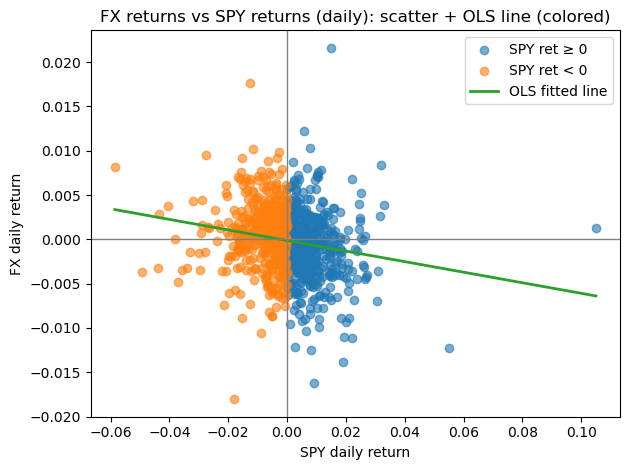

In [14]:
if usa.shape[0] == 0 or bcrp_wide.shape[0] == 0:
    print("USA or BCRP wide data is empty. Cannot perform analysis.")
else:
    # 1. Compute FX_change from bcrp_wide (using fx_interbank_buy)
    fx_data = bcrp_wide[['date', 'fx_interbank_buy']].copy()
    fx_data['date'] = pd.to_datetime(fx_data['date'])
    fx_data = fx_data.set_index('date').sort_index()
    fx_data['FX_change'] = fx_data['fx_interbank_buy'].pct_change(fill_method=None) # Add fill_method=None to avoid FutureWarning

    # 2. Extract SPY_ret from usa data
    spy_data = usa[usa['ticker'] == 'SPY'].copy()
    spy_data['date'] = pd.to_datetime(spy_data['date'])
    spy_data = spy_data.set_index('date').sort_index()
    # Ensure 'ret' is computed, though it should be by yfinance_download
    if 'ret' not in spy_data.columns or spy_data['ret'].isna().all():
        spy_data['ret'] = spy_data['close'].pct_change()
    spy_data = spy_data.rename(columns={'ret': 'SPY_ret'})

    # 3. Merge FX_change and SPY_ret on date
    merged_data = pd.merge(
        fx_data[['FX_change']],
        spy_data[['SPY_ret']],
        left_index=True,
        right_index=True,
        how='inner'
    ).dropna()

    if merged_data.empty:
        print("No overlapping dates or valid data after merging FX_change and SPY_ret.")
    else:
        x = merged_data['SPY_ret'].to_numpy()
        y = merged_data['FX_change'].to_numpy()

        if len(x) < 5:
            print("Not enough overlapping observations for regression.")
        else:
            # Closed-form OLS
            x_mean = x.mean()
            y_mean = y.mean()
            cov_xy = np.mean((x - x_mean) * (y - y_mean))
            var_x  = np.mean((x - x_mean) ** 2)

            beta = cov_xy / var_x
            alpha = y_mean - beta * x_mean

            print("OLS (closed-form) results")
            print("alpha:", alpha)
            print("beta :", beta)
            print("N    :", len(x))

            # Color points by SPY sign
            pos = x >= 0
            neg = ~pos

            plt.figure()
            plt.scatter(x[pos], y[pos], alpha=0.6, label="SPY ret ≥ 0", color="tab:blue")
            plt.scatter(x[neg], y[neg], alpha=0.6, label="SPY ret < 0", color="tab:orange")

            # Fitted line
            x_line = np.linspace(x.min(), x.max(), 200)
            y_line = alpha + beta * x_line
            plt.plot(x_line, y_line, linewidth=2, label="OLS fitted line", color="tab:green")

            plt.axhline(0, linewidth=1, color="gray")
            plt.axvline(0, linewidth=1, color="gray")
            plt.title("FX returns vs SPY returns (daily): scatter + OLS line (colored)")
            plt.xlabel("SPY daily return")
            plt.ylabel("FX daily return")
            plt.legend()
            plt.tight_layout()
            plt.show()

12. Compute the **correlation** between `FX_change` and `SPY_ret` and explain the sign.  


In [15]:
if 'merged_data' in locals() and not merged_data.empty:
    correlation = merged_data['FX_change'].corr(merged_data['SPY_ret'])
    print(f"Correlation between FX_change and SPY_ret: {correlation:.4f}")
    if correlation > 0:
        print("\nA positive correlation suggests that when SPY returns are positive, FX_change tends to be positive as well, and vice versa. This indicates that the Peruvian Sol tends to strengthen against the USD when the US stock market (represented by SPY) performs well.")
    elif correlation < 0:
        print("\nA negative correlation suggests that when SPY returns are positive, FX_change tends to be negative, and vice versa. This indicates that the Peruvian Sol tends to weaken against the USD when the US stock market (represented by SPY) performs well.")
    else:
        print("\nA correlation close to zero suggests little linear relationship between FX_change and SPY_ret.")
else:
    print("merged_data is not available or is empty. Please ensure the previous cell for merging data ran successfully.")

Correlation between FX_change and SPY_ret: -0.1781

A negative correlation suggests that when SPY returns are positive, FX_change tends to be negative, and vice versa. This indicates that the Peruvian Sol tends to weaken against the USD when the US stock market (represented by SPY) performs well.


13. Estimate a simple regression `FX_change ~ SPY_ret` and interpret the coefficient.  


In [16]:
# Check whether the DataFrame 'merged_data' exists in the local environment
# and is not empty to avoid runtime errors
if 'merged_data' in locals() and not merged_data.empty:
    
    # Extract the relevant columns and convert them to NumPy arrays
    # x: SPY returns (independent variable)
    # y: exchange rate changes (dependent variable)
    x = merged_data['SPY_ret'].to_numpy()
    y = merged_data['FX_change'].to_numpy()

    # Ensure there are enough observations for a meaningful regression
    # At least 5 observations are required
    if len(x) < 5:
        print("Not enough overlapping observations for regression.")
    else:
        
        
        # Closed-form Ordinary Least Squares
         

        # Compute the sample means of x and y
        x_mean = x.mean()
        y_mean = y.mean()

        # Compute the covariance between x and y
        # This captures the joint movement of the two variables
        cov_xy = np.mean((x - x_mean) * (y - y_mean))

        # Compute the variance of x
        # This measures the dispersion of the independent variable
        var_x = np.mean((x - x_mean) ** 2)

        # Compute the slope coefficient (beta)
        # Beta measures the sensitivity of y to changes in x
        beta = cov_xy / var_x

        # Compute the intercept (alpha)
        # Alpha represents the expected value of y when x = 0
        alpha = y_mean - beta * x_mean

        # Display the regression results
        print("OLS (closed-form) results")
        print(f"alpha: {alpha:.6f}")
        print(f"beta : {beta:.6f}")
        print(f"N    : {len(x)}")

else:
    # Error message if the DataFrame does not exist or is empty
    print("merged_data is not available or is empty. Please ensure the previous cell for merging data ran successfully.")


OLS (closed-form) results
alpha: -0.000130
beta : -0.059588
N    : 922


14. *(Pandas)* Do a selection exercise: `.iloc` (position-based) vs conditional filtering.  


In [17]:
print("Demonstration of .iloc (position-based selection):")

# Select the first 5 rows and the first 3 columns of the DataFrame 'usa'
# Columns are selected strictly by their positional index
# We only verify here that the DataFrame is not empty
if usa.empty:
    print("The DataFrame 'usa' is empty, so .iloc cannot be demonstrated.")
else:
    display(usa.iloc[0:5, 0:3])

    # Select a specific row and column using positional indices
    print("\nSelect the value from the third row (index 2) and the fourth column (index 3):")
    if usa.shape[0] > 2 and usa.shape[1] > 3:
        display(usa.iloc[2, 3])
    else:
        print("The DataFrame 'usa' does not have enough rows or columns for this specific selection.")





Demonstration of .iloc (position-based selection):


Price,date,ticker,close
0,2022-01-03,GLD,168.330002
1,2022-01-04,GLD,169.570007
2,2022-01-05,GLD,169.059998
3,2022-01-06,GLD,166.990005
4,2022-01-07,GLD,167.750000



Select the value from the third row (index 2) and the fourth column (index 3):


np.int64(8715600)

In [18]:
###Conditional filtering

print("Demostración de filtrado condicional:")
# Seleccionar todas las filas donde el ticker es 'SPY'
if usa.empty:
    print("El DataFrame 'usa' está vacío, no se puede demostrar el filtrado condicional.")
else:
    spy_data_filtered = usa[usa['ticker'] == 'SPY']
    print("\nDatos de SPY (primeras 5 filas):")
    display(spy_data_filtered.head())

    # Seleccionar filas donde el ticker es 'TLT' y el retorno es negativo
    tlt_negative_returns = usa[(usa['ticker'] == 'TLT') & (usa['ret'] < 0)]
    print("\nDatos de TLT con retornos negativos (primeras 5 filas):")
    display(tlt_negative_returns.head())

Demostración de filtrado condicional:

Datos de SPY (primeras 5 filas):


Price,date,ticker,close,volume,ret
994,2022-01-03,SPY,477.709991,72668200,NaN
995,2022-01-04,SPY,477.549988,71178700,-0.000335
996,2022-01-05,SPY,468.380005,104538900,-0.019202
997,2022-01-06,SPY,467.940002,86858900,-0.000939
998,2022-01-07,SPY,466.089996,85111600,-0.003954



Datos de TLT con retornos negativos (primeras 5 filas):


Price,date,ticker,close,volume,ret
1989,2022-01-04,TLT,143.699997,21996400,-0.004158
1990,2022-01-05,TLT,142.919998,20911700,-0.005428
1992,2022-01-07,TLT,142.259995,18756800,-0.007188
1995,2022-01-12,TLT,143.009995,14440600,-0.003831
1997,2022-01-14,TLT,142.100006,22997500,-0.015109


15. Create missing data on purpose in one series and apply imputation (as in the notebook).  


C:\Users\ASUS\AppData\Local\Temp\ipykernel_40492\2976556078.py:19: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  spy_close_imputed = spy_close_missing.fillna(method='ffill')


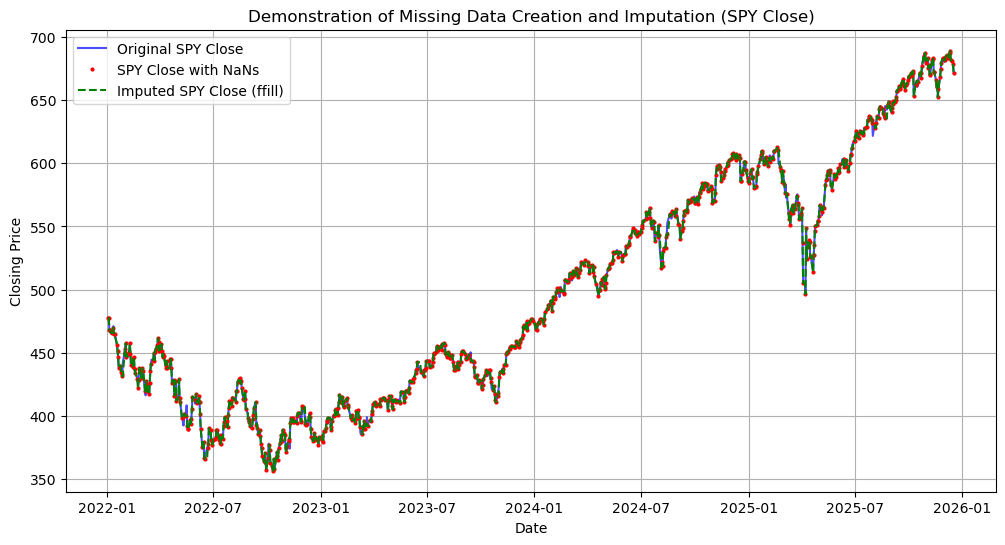

NaNs in the original series: 0
NaNs in the series with missing data: 99
NaNs in the imputed series: 0


In [19]:
if usa.empty:
    print("The DataFrame 'usa' is empty; missing data creation and imputation cannot be demonstrated.")
else:
    # Select the SPY closing price series
    spy_close = usa[usa['ticker'] == 'SPY'].set_index('date')['close'].sort_index().copy()

    # Create a copy to intentionally introduce missing data
    spy_close_missing = spy_close.copy()

    # Introduce NaNs in approximately 10% of the data at random
    missing_indices = np.random.choice(
        spy_close_missing.index,
        size=int(len(spy_close_missing) * 0.1),
        replace=False
    )
    spy_close_missing.loc[missing_indices] = np.nan

    # Apply imputation: forward fill
    spy_close_imputed = spy_close_missing.fillna(method='ffill')

    # Visualize the results
    plt.figure(figsize=(12, 6))
    plt.plot(spy_close, label='Original SPY Close', color='blue', alpha=0.7)
    plt.plot(spy_close_missing, 'o', label='SPY Close with NaNs', color='red', markersize=2)
    plt.plot(spy_close_imputed, label='Imputed SPY Close (ffill)', color='green', linestyle='--')
    plt.title('Demonstration of Missing Data Creation and Imputation (SPY Close)')
    plt.xlabel('Date')
    plt.ylabel('Closing Price')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Display the number of NaNs before and after imputation
    print(f"NaNs in the original series: {spy_close.isnull().sum()}")
    print(f"NaNs in the series with missing data: {spy_close_missing.isnull().sum()}")
    print(f"NaNs in the imputed series: {spy_close_imputed.isnull().sum()}")


16. Standardize a variable (z-score) and plot **before vs after**.  


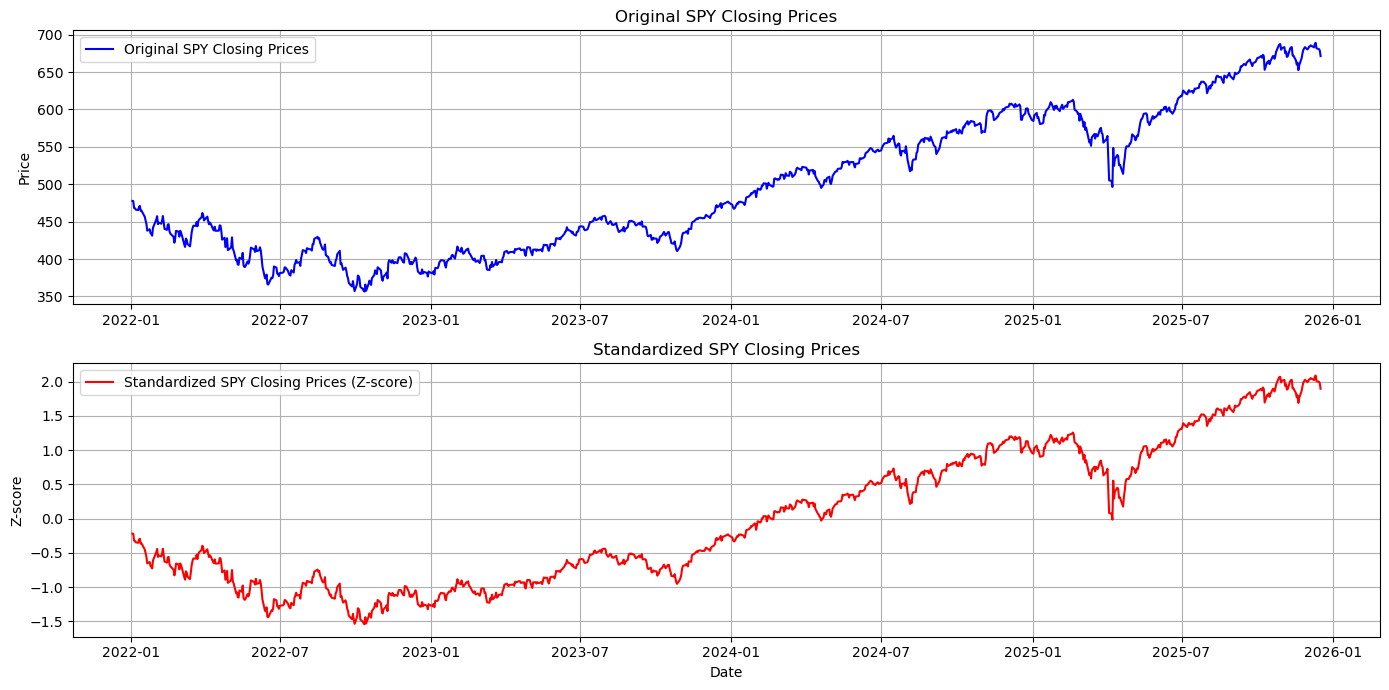

In [20]:
if usa.empty:
    print("The DataFrame 'usa' is empty; standardization cannot be demonstrated.")
else:
    # Select the SPY closing price series
    spy_close = usa[usa['ticker'] == 'SPY'].set_index('date')['close'].sort_index().copy()

    if spy_close.empty:
        print("There is no SPY data in the 'usa' DataFrame.")
    else:
        # Compute the mean and standard deviation of the original series
        mean_spy_close = spy_close.mean()
        std_spy_close = spy_close.std()

        # Compute the z-score (standardization)
        spy_close_standardized = (spy_close - mean_spy_close) / std_spy_close

        # Visualize the original vs. standardized series
        plt.figure(figsize=(14, 7))

        plt.subplot(2, 1, 1)
        plt.plot(spy_close, label='Original SPY Closing Prices', color='blue')
        plt.title('Original SPY Closing Prices')
        plt.ylabel('Price')
        plt.legend()
        plt.grid(True)

        plt.subplot(2, 1, 2)
        plt.plot(spy_close_standardized, label='Standardized SPY Closing Prices (Z-score)', color='red')
        plt.title('Standardized SPY Closing Prices')
        plt.xlabel('Date')
        plt.ylabel('Z-score')
        plt.legend()
        plt.grid(True)

        plt.tight_layout()
        plt.show()

        # Display some statistics for verification



17. Find the day with the largest `|SPY_ret|` and **annotate it** in the returns plot (like the exercise).  


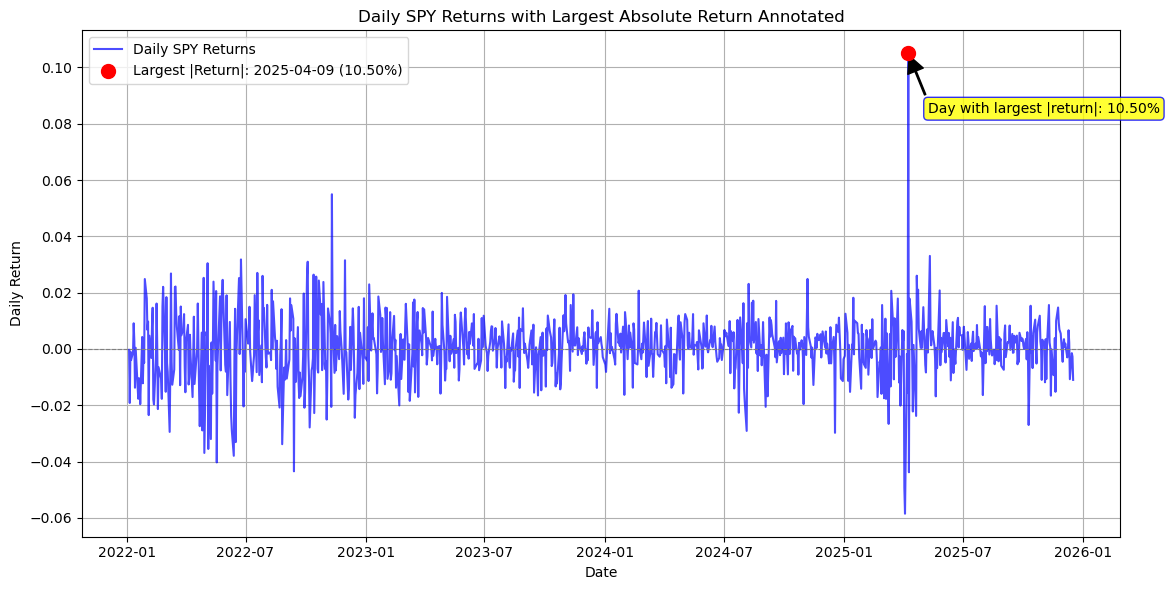

Figure saved to: figures\spy_returns_annotated.png


In [21]:
import os
import matplotlib.pyplot as plt
import pandas as pd

if usa.empty:
    print("The 'usa' DataFrame is empty; SPY returns analysis cannot be performed.")
else:
    # Filter SPY data and ensure that 'ret' is calculated
    spy_data = usa[usa['ticker'] == 'SPY'].copy()
    spy_data['date'] = pd.to_datetime(spy_data['date'])
    spy_data = spy_data.set_index('date').sort_index()

    if 'ret' not in spy_data.columns or spy_data['ret'].isna().all():
        spy_data['ret'] = spy_data['close'].pct_change()

    spy_returns = spy_data['ret'].dropna()

    if spy_returns.empty:
        print("No SPY returns are available for analysis.")
    else:
        # Find the day with the largest absolute return
        largest_abs_ret_date = spy_returns.abs().idxmax()
        largest_abs_ret_value = spy_returns.loc[largest_abs_ret_date]

        # Create the SPY returns plot
        plt.figure(figsize=(12, 6))
        plt.plot(
            spy_returns.index,
            spy_returns.values,
            label='Daily SPY Returns',
            color='blue',
            alpha=0.7
        )

        # Highlight the day with the largest absolute return
        plt.scatter(
            largest_abs_ret_date,
            largest_abs_ret_value,
            color='red',
            s=100,
            zorder=5,
            label=(
                f'Largest |Return|: '
                f'{largest_abs_ret_date.strftime("%Y-%m-%d")} '
                f'({largest_abs_ret_value:.2%})'
            )
        )

        plt.annotate(
            f'Day with largest |return|: {largest_abs_ret_value:.2%}',
            xy=(largest_abs_ret_date, largest_abs_ret_value),
            xytext=(largest_abs_ret_date + pd.DateOffset(days=30),
                    largest_abs_ret_value * 0.8),
            arrowprops=dict(facecolor='black', shrink=0.05, width=1),
            bbox=dict(boxstyle="round,pad=0.3", fc="yellow", ec="b", lw=1, alpha=0.8),
            fontsize=10
        )

        plt.title('Daily SPY Returns with Largest Absolute Return Annotated')
        plt.xlabel('Date')
        plt.ylabel('Daily Return')
        plt.axhline(0, color='gray', linestyle='--', linewidth=0.8)
        plt.legend()
        plt.grid(True)
        plt.tight_layout()

        # Save the figure
        output_dir = 'figures'
        os.makedirs(output_dir, exist_ok=True)
        filename = os.path.join(output_dir, 'spy_returns_annotated.png')
        plt.savefig(filename, dpi=300, bbox_inches='tight')

        plt.show()

        print(f"Figure saved to: {filename}")


18. Save one figure into `/figures` using `savefig` and verify the file exists.  


In [22]:
import os

filename = 'figures/spy_returns_annotated.png'

if os.path.exists(filename):
    print(f"Verification: File {filename} exists.")
else:
    print(f"Verification: File {filename} was NOT created.")


Verification: File figures/spy_returns_annotated.png exists.


19. Build a **summary stats table** for returns (mean, sd, p5, p95, etc.).  


In [23]:
if usa.empty:
    print("The DataFrame 'usa' is empty; return statistics cannot be calculated.")
else:
    # Ensure that the 'ret' column is calculated in the 'usa' DataFrame
    # This should already have been done in cell 5, but it is included here for robustness.
    usa_returns = usa.copy()
    usa_returns['date'] = pd.to_datetime(usa_returns['date'], errors='coerce')
    usa_returns = usa_returns.sort_values(['ticker', 'date']).reset_index(drop=True)

    if 'ret' not in usa_returns.columns or usa_returns['ret'].isna().all():
        usa_returns['ret'] = usa_returns.groupby('ticker')['close'].apply(pct_change).reset_index(level=0, drop=True)

    # Pivot to have returns for each ticker as columns
    returns_wide = usa_returns.pivot_table(index='date', columns='ticker', values='ret')

    # Compute summary statistics
    summary_stats = returns_wide.describe(
        percentiles=[.01, .05, .10, .25, .50, .75, .90, .95, .99]
    ).T

    # Rename columns for clarity
    summary_stats = summary_stats.rename(columns={
        'mean': 'Mean',
        'std': 'Std Dev',
        'min': 'Min',
        'max': 'Max',
        '1%': 'P1',
        '5%': 'P5',
        '10%': 'P10',
        '25%': 'P25',
        '50%': 'Median',
        '75%': 'P75',
        '90%': 'P90',
        '95%': 'P95',
        '99%': 'P99'
    })

    # Select and reorder the desired columns
    cols = [
        'Mean', 'Std Dev', 'Min', 'P1', 'P5', 'P10', 'P25',
        'Median', 'P75', 'P90', 'P95', 'P99', 'Max', 'count'
    ]
    summary_stats = summary_stats[cols]

    print("Summary Statistics Table for Daily Returns:")
    display(summary_stats)


Summary Statistics Table for Daily Returns:


,Mean,Std Dev,Min,P1,P5,P10,P25,Median,P75,P90,P95,P99,Max,count
ticker,,,,,,,,,,,,,,
GLD,0.000920,0.010029,-0.064269,-0.024037,-0.015494,-0.010896,-0.004962,0.000804,0.006606,0.013033,0.017195,0.027412,0.036991,993.0
SPY,0.000408,0.011408,-0.058543,-0.032104,-0.017097,-0.012614,-0.005150,0.000559,0.006334,0.012496,0.017664,0.026392,0.105019,993.0
TLT,-0.000446,0.010441,-0.034183,-0.025701,-0.017863,-0.013867,-0.007188,-0.000193,0.005894,0.012204,0.016555,0.024275,0.038474,993.0


20. Compute **historical 95% VaR** for a **60/40 portfolio (SPY/TLT)** and explain what it means.


In [24]:
if usa.empty:
    print("The DataFrame 'usa' is empty; VaR cannot be calculated.")
else:
    # Ensure that the 'ret' column is calculated in the 'usa' DataFrame
    usa_returns = usa.copy()
    usa_returns['date'] = pd.to_datetime(usa_returns['date'], errors='coerce')
    usa_returns = usa_returns.sort_values(['ticker', 'date']).reset_index(drop=True)

    if 'ret' not in usa_returns.columns or usa_returns['ret'].isna().all():
        usa_returns['ret'] = usa_returns.groupby('ticker')['close'].apply(pct_change).reset_index(level=0, drop=True)

    # Filter only SPY and TLT and pivot to wide format
    portfolio_returns = (
        usa_returns[usa_returns['ticker'].isin(['SPY', 'TLT'])]
        .pivot_table(index='date', columns='ticker', values='ret')
        .dropna()
    )

    if portfolio_returns.empty:
        print("There is not enough data for SPY and/or TLT to calculate portfolio returns.")
    else:
        # Define portfolio weights (60% SPY, 40% TLT)
        weights = {'SPY': 0.60, 'TLT': 0.40}

        # Calculate portfolio returns
        # Ensure that tickers in `weights` match the columns in `portfolio_returns`
        weighted_returns = portfolio_returns[list(weights.keys())].mul(pd.Series(weights))
        portfolio_ret = weighted_returns.sum(axis=1)

        # Calculate historical 95% VaR
        # A 95% VaR corresponds to the 5th percentile (lower tail of the return distribution)
        var_95 = portfolio_ret.quantile(0.05)

        print(f"Historical 95% VaR for the portfolio (60% SPY / 40% TLT): {var_95:.4f}")

        # VaR explanation
        print("\nVaR Explanation:")
        print(
            f"The 95% Value at Risk (VaR) of {var_95:.4f} means that, based on historical data,"
        )
        print(
            f"there is a 5% probability that the portfolio will lose {abs(var_95):.2%} or more in a single day."
        )
        print(
            f"Alternatively, there is a 95% probability that the portfolio loss will not exceed {abs(var_95):.2%} in a single day."
        )


Historical 95% VaR for the portfolio (60% SPY / 40% TLT): -0.0137

VaR Explanation:
The 95% Value at Risk (VaR) of -0.0137 means that, based on historical data,
there is a 5% probability that the portfolio will lose 1.37% or more in a single day.
Alternatively, there is a 95% probability that the portfolio loss will not exceed 1.37% in a single day.
